# Import

In [49]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Data

In [50]:
path = "dataset/train.csv"
df_train = pd.read_csv(path)

path = "dataset/test.csv"
df_test = pd.read_csv(path)

In [51]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 co

In [52]:
# print(df_train)
# print(df_test)

In [53]:
# Check Duplication row in training data
print(df_train.duplicated().sum())

0


In [54]:
# All of the rows inside df_test seems to be also inside the df_train
duplicates = pd.merge(df_train, df_test, how='inner')
duplicates

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
1,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no
2,57,services,married,secondary,no,162,yes,no,unknown,5,may,174,1,-1,0,unknown,no
3,57,technician,married,secondary,no,839,no,yes,unknown,5,may,225,1,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,35,technician,married,secondary,no,0,yes,no,cellular,9,nov,524,1,96,5,success,yes
4517,36,admin.,single,tertiary,no,980,no,no,cellular,11,nov,118,4,104,7,failure,no
4518,75,retired,divorced,tertiary,no,3810,yes,no,cellular,16,nov,262,1,183,1,failure,yes
4519,36,management,single,secondary,no,1511,yes,no,cellular,16,nov,270,1,-1,0,unknown,yes


In [55]:
# # Unique values in each column
# for col in df_train:
#     print(f'+ Unique values in {col}: {df_train[col].unique()}')

In [56]:
# Number of unique values
df_train.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

In [57]:
# count each categorical variable frequency
cate_var = df_train.select_dtypes(include=object)
for col in cate_var.columns:
    print(f"{df_train[col].value_counts()}, \n")

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64, 

marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64, 

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64, 

default
no     44396
yes      815
Name: count, dtype: int64, 

housing
yes    25130
no     20081
Name: count, dtype: int64, 

loan
no     37967
yes     7244
Name: count, dtype: int64, 

contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64, 

month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64, 

poutcome
unknown    36959


In [58]:
# summary each numerical variable
num_var = df_train.select_dtypes(include=int)
for col in num_var.columns:
    print(f"{df_train[col].describe()}, \n")

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64, 

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64, 

count    45211.000000
mean        15.806419
std          8.322476
min          1.000000
25%          8.000000
50%         16.000000
75%         21.000000
max         31.000000
Name: day, dtype: float64, 

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64, 

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max      

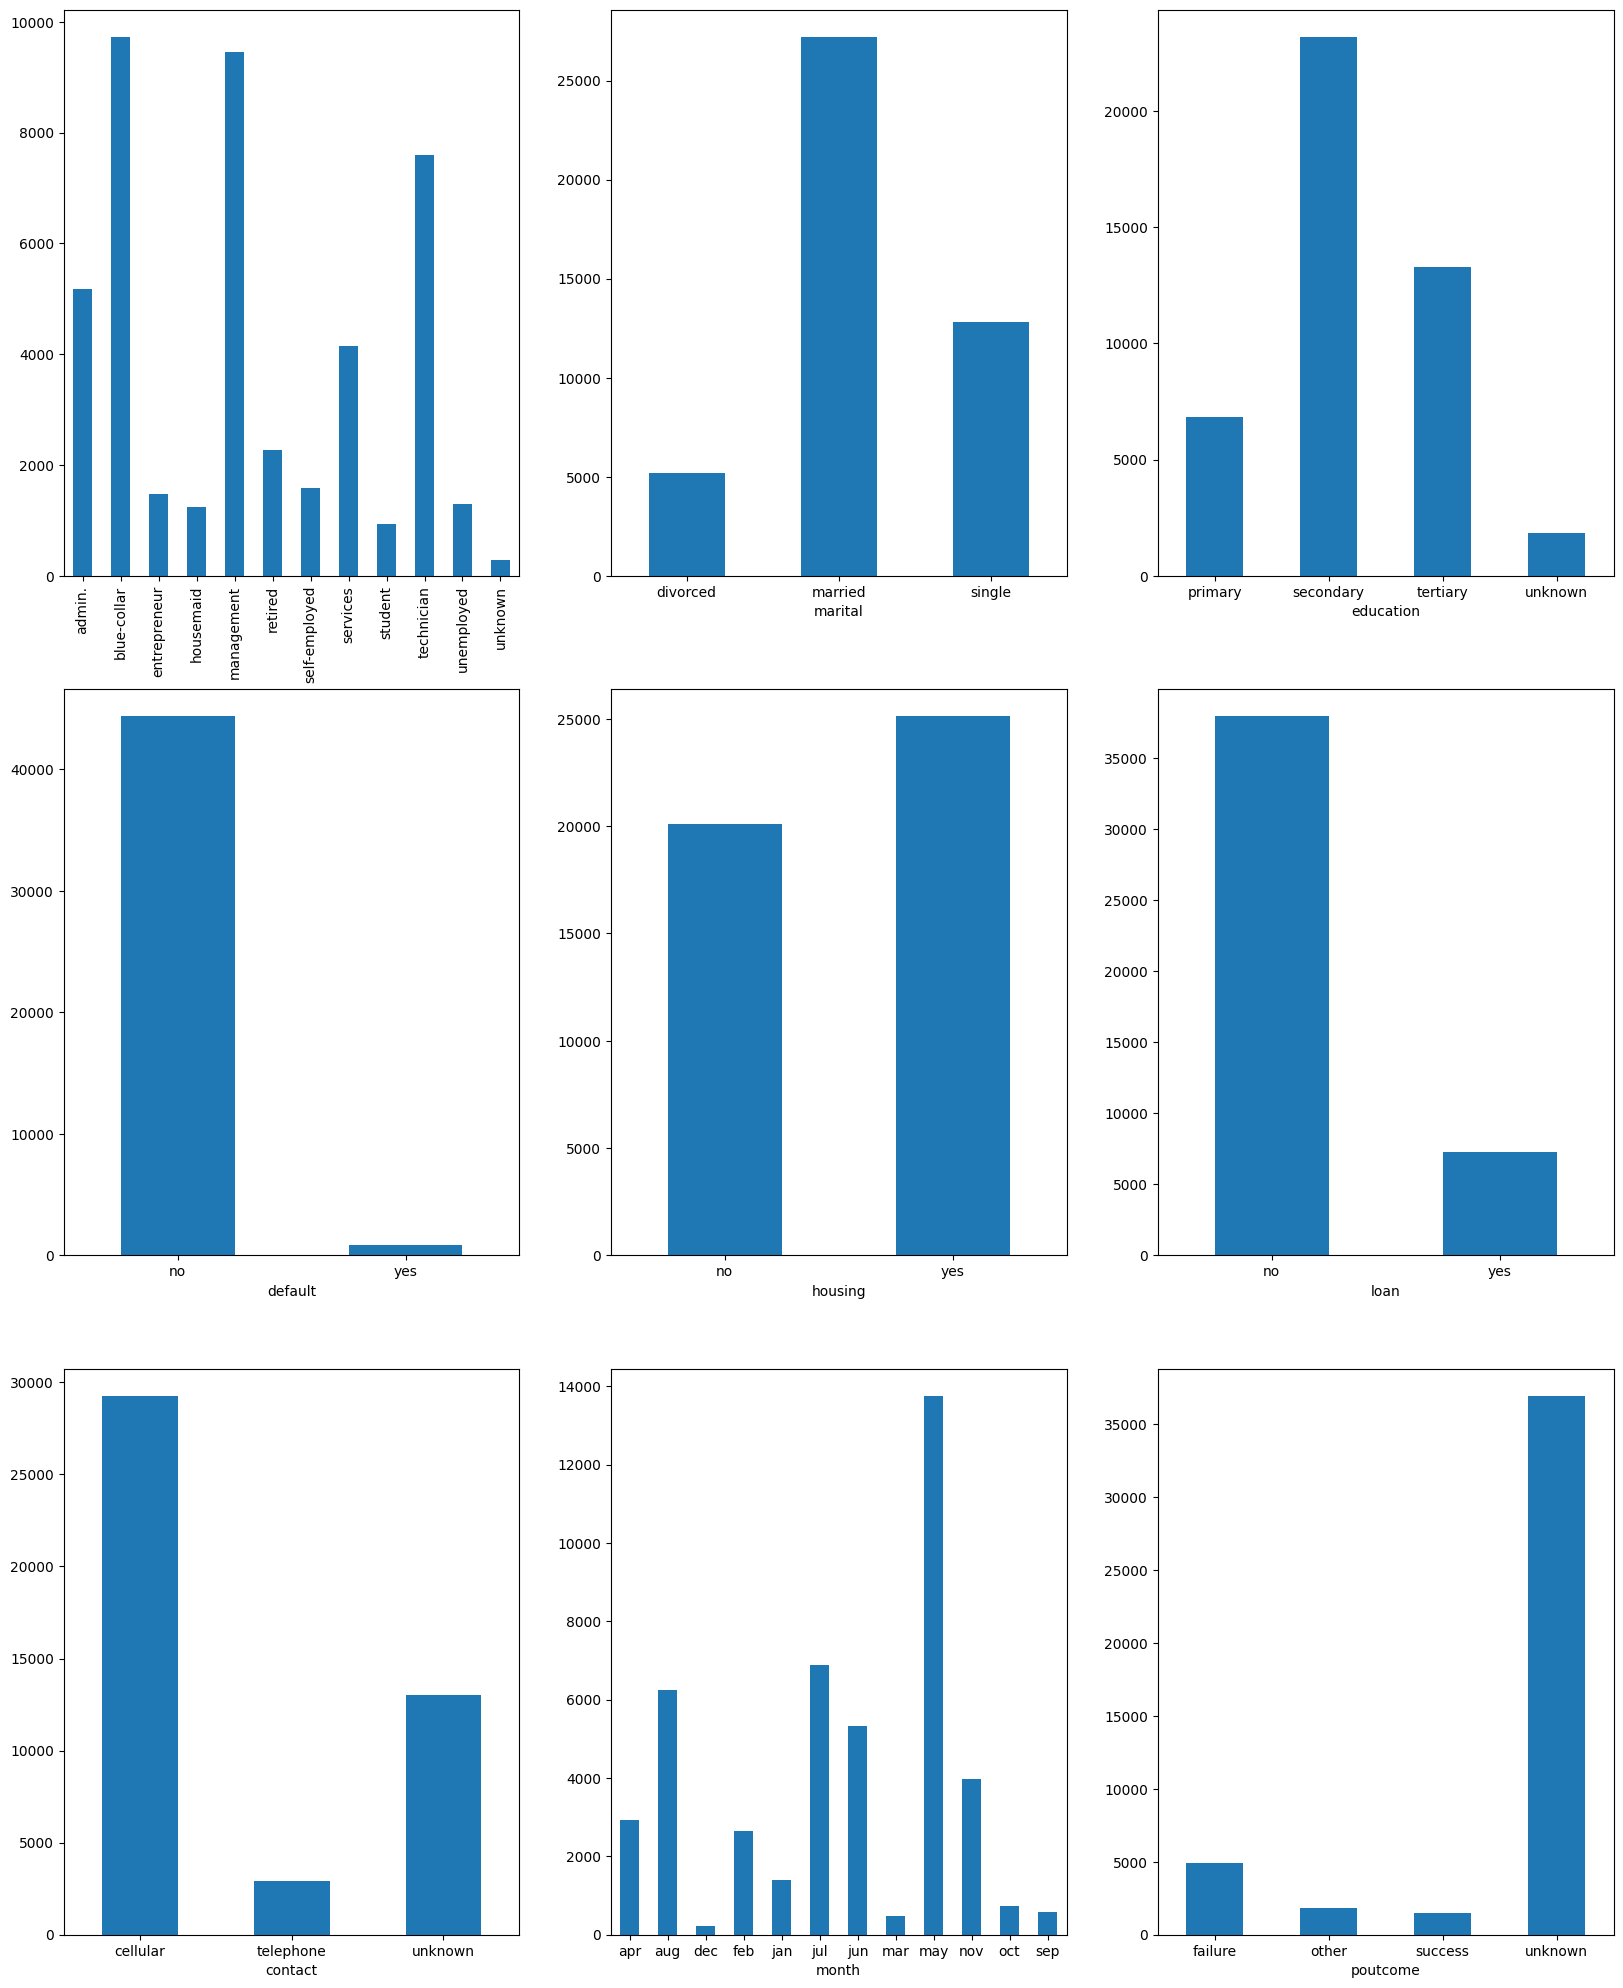

In [59]:
# visualization of categorical variables
cate_var = df_train.select_dtypes(include=object)
cate_var = cate_var.drop('y', axis=1)
fig, axes = plt.subplots(3, 3, figsize=(20, 25))

job = cate_var.groupby('job')['job'].count()
job.plot(kind='bar', ax=axes[0,0])

marital = cate_var.groupby('marital')['marital'].count()
marital.plot(kind='bar', ax=axes[0,1], rot=0)

education = cate_var.groupby('education')['education'].count()
education.plot(kind='bar', ax=axes[0,2], rot=0)

default = cate_var.groupby('default')['default'].count()
default.plot(kind='bar', ax=axes[1,0], rot=0)

housing = cate_var.groupby('housing')['housing'].count()
housing.plot(kind='bar', ax=axes[1,1], rot=0)

loan = cate_var.groupby('loan')['loan'].count()
loan.plot(kind='bar', ax=axes[1,2], rot=0)

contact = cate_var.groupby('contact')['contact'].count()
contact.plot(kind='bar', ax=axes[2,0], rot=0)

month = cate_var.groupby('month')['month'].count()
month.plot(kind='bar', ax=axes[2,1], rot=0)

poutcome = cate_var.groupby('poutcome')['poutcome'].count()
poutcome.plot(kind='bar', ax=axes[2,2], rot=0)

plt.savefig('eda_cate.png', bbox_inches='tight')

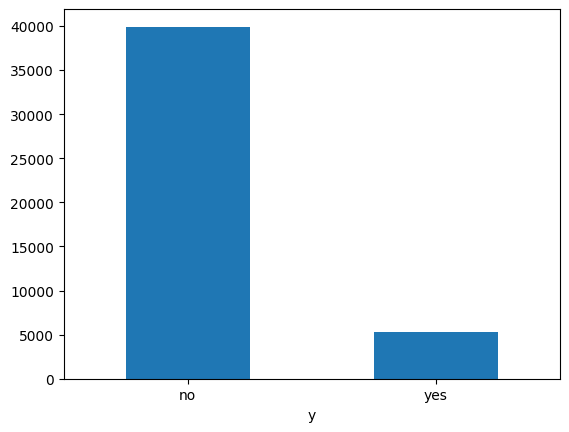

In [60]:
# dependent variable
cate_var = df_train.select_dtypes(include=object)

y = cate_var.groupby('y')['y'].count()
y.plot(kind='bar', rot=0)

plt.savefig('y.png', bbox_inches='tight')

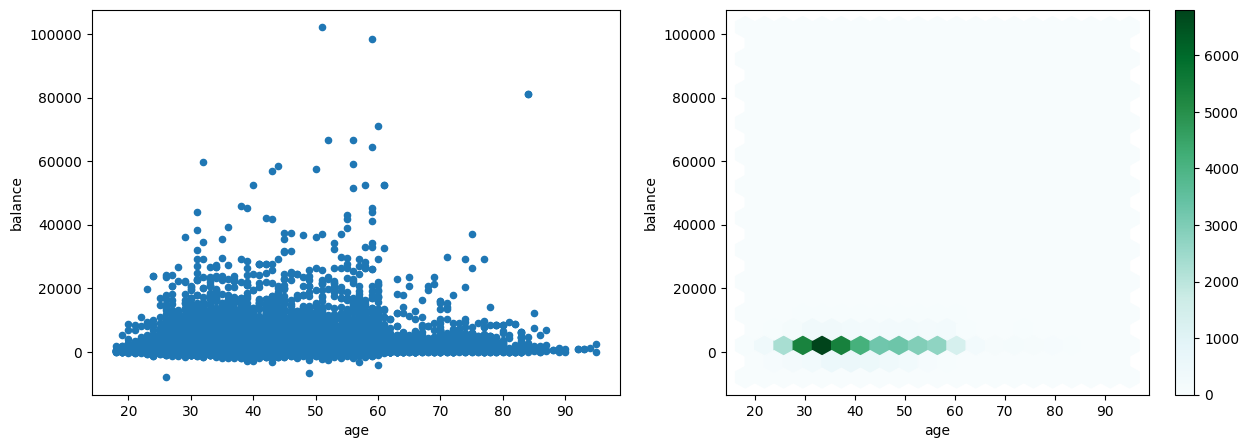

In [61]:
# scatterplot, hexagonal binning of balance and age variables
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

df_train.plot(kind='scatter', x='age', y='balance', ax=axes[0])
df_train.plot(kind='hexbin', x='age', y='balance', gridsize=20, ax=axes[1])

plt.savefig('age_balance.png', bbox_inches='tight')

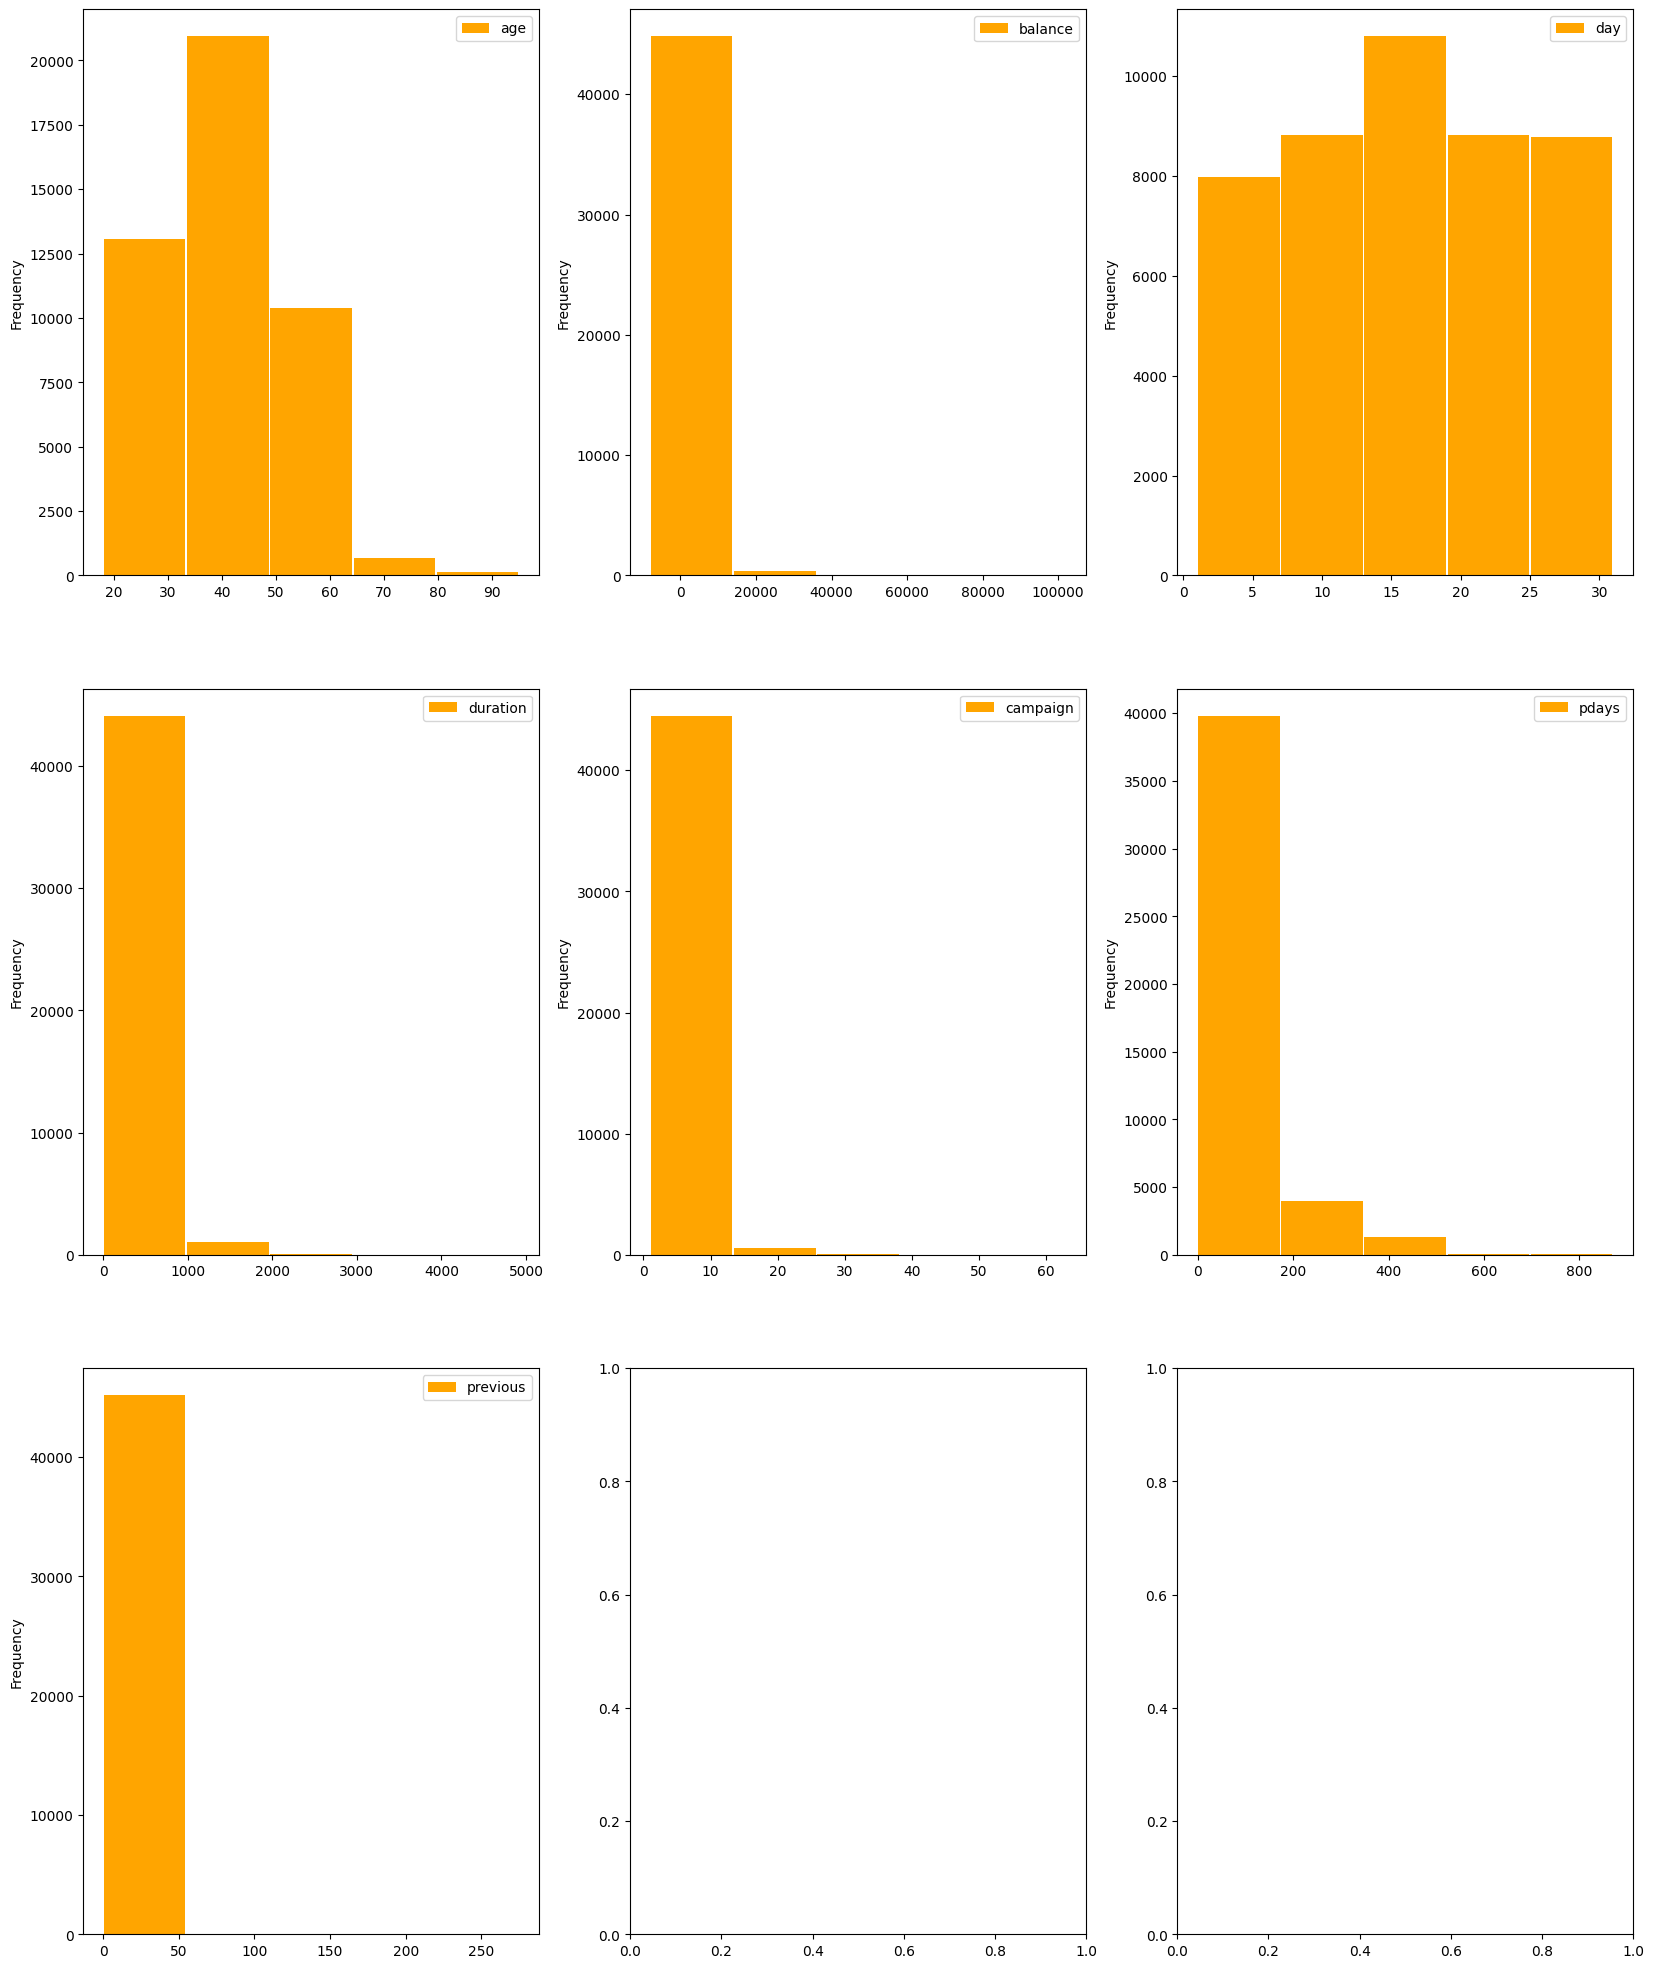

In [62]:
# visualization of categorical variables
num_var = df_train.select_dtypes(include=int)
fig, axes = plt.subplots(3, 3, figsize=(20, 25))

num_var.plot(kind='hist', column='age', bins=5, rwidth=0.98, color='orange', ax=axes[0,0])

num_var.plot(kind='hist', column='balance', bins=5, rwidth=0.98, color='orange', ax=axes[0,1])

num_var.plot(kind='hist', column='day', bins=5, rwidth=0.98, color='orange', ax=axes[0,2])

num_var.plot(kind='hist', column='duration', bins=5, rwidth=0.98, color='orange', ax=axes[1,0])

num_var.plot(kind='hist', column='campaign', bins=5, rwidth=0.98, color='orange', ax=axes[1,1])

num_var.plot(kind='hist', column='pdays', bins=5, rwidth=0.98, color='orange', ax=axes[1,2])

num_var.plot(kind='hist', column='previous', bins=5, rwidth=0.98, color='orange', ax=axes[2,0])

plt.savefig('eda_num.png', bbox_inches='tight')

In [63]:
# Merge train and test dataset and Drop Duplicate row 
merge_train_test = pd.concat([df_train, df_test])
new_df = merge_train_test.drop_duplicates()
# new_df

In [64]:
# Number of yes and no in the response feature, only around 12% yes out of all
counts = new_df['y'].value_counts()
counts

y
no     39922
yes     5289
Name: count, dtype: int64

# Split Data

In [65]:
X = new_df.iloc[:,:16]
y = new_df.iloc[:,16]

X_train, X_temp, y_train, y_temp = train_test_split(X,y, random_state=42, test_size=0.2, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(X_temp,y_temp, random_state=42, test_size=0.5, stratify=y_temp)

# Data Preprocessing

In [66]:
numeric_features = ['age','balance','day','duration','campaign','pdays','previous']

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_features = ['job','marital','education','default','housing',
                        'loan','contact','month','poutcome']

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Fit and transform the training data and transform the val and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

In [67]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Percentages of yes in each of train, val, test dataset
print(sum(y_train)/len(y_train))
print(sum(y_val)/len(y_val))
print(sum(y_test)/len(y_test))

label_names = label_encoder.classes_
label_names

0.11698186241981863
0.11698363555948696
0.11700951117009512


array(['no', 'yes'], dtype=object)

# Models Assessment with default hyperparameters:

In [68]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## DecisionTree

In [69]:
decisiontreeclf = DecisionTreeClassifier()
# print(decisiontreeclf.get_params())

print(cross_val_score(decisiontreeclf, X_train_transformed, y_train, cv=kfold, scoring='f1').mean())

0.4813361889854157


## RandomForest

In [70]:
randomforestclf = RandomForestClassifier()
# print(randomforestclf.get_params())

print(cross_val_score(randomforestclf, X_train_transformed, y_train, cv=kfold, scoring='f1').mean())

0.4953600575983258


## AdaBoost

In [71]:
adaclf = AdaBoostClassifier(algorithm="SAMME")
# print(adaclf.get_params())

print(cross_val_score(adaclf, X_train_transformed, y_train, cv=kfold, scoring='f1').mean())

0.4270184107361099


## GradientBoosting

In [72]:
gbclf = GradientBoostingClassifier()
# print(gbclf.get_params())

print(cross_val_score(gbclf, X_train_transformed, y_train, cv=kfold, scoring='f1').mean())

0.5089385103541033


## XGBoost

In [73]:
xgbclf = xgb.XGBClassifier()
# print(xgbclf.get_params())

print(cross_val_score(xgbclf, X_train_transformed, y_train, cv=kfold, scoring='f1').mean())

0.5567000077176639


# Preliminary XGBoost Model:

In [74]:
xgbclf1 = xgb.XGBClassifier(
    objective="binary:logistic",
    seed=42,
    eval_metric="aucpr",
    n_estimators=200,
    early_stopping_rounds=10,
    tree_method='exact',
    booster='gbtree',
)

model1 = xgbclf1.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_train_transformed, y_train), (X_val_transformed, y_val)],
    verbose=True,
)

[0]	validation_0-aucpr:0.56060	validation_1-aucpr:0.53469
[1]	validation_0-aucpr:0.59625	validation_1-aucpr:0.54518
[2]	validation_0-aucpr:0.61789	validation_1-aucpr:0.56162
[3]	validation_0-aucpr:0.63357	validation_1-aucpr:0.56959
[4]	validation_0-aucpr:0.64069	validation_1-aucpr:0.56812
[5]	validation_0-aucpr:0.65551	validation_1-aucpr:0.57236
[6]	validation_0-aucpr:0.65972	validation_1-aucpr:0.57662
[7]	validation_0-aucpr:0.66694	validation_1-aucpr:0.58079
[8]	validation_0-aucpr:0.67399	validation_1-aucpr:0.57892
[9]	validation_0-aucpr:0.67839	validation_1-aucpr:0.57867
[10]	validation_0-aucpr:0.68692	validation_1-aucpr:0.58347
[11]	validation_0-aucpr:0.69097	validation_1-aucpr:0.58902
[12]	validation_0-aucpr:0.69527	validation_1-aucpr:0.59121
[13]	validation_0-aucpr:0.70142	validation_1-aucpr:0.59527
[14]	validation_0-aucpr:0.71210	validation_1-aucpr:0.59929
[15]	validation_0-aucpr:0.71592	validation_1-aucpr:0.60144
[16]	validation_0-aucpr:0.72177	validation_1-aucpr:0.60219
[17]	va

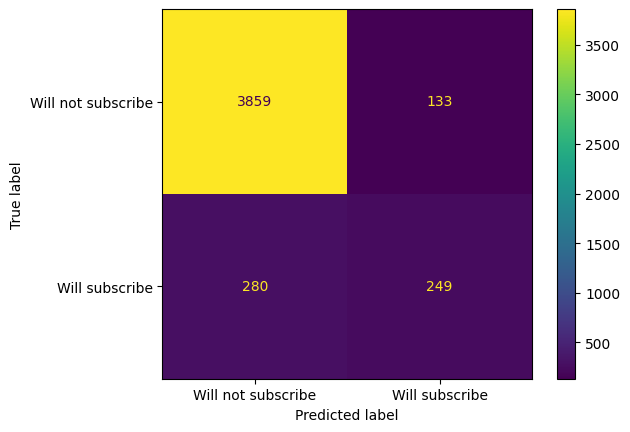

In [75]:
predictions = model1.predict(X_test_transformed)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Will not subscribe', 'Will subscribe'])
disp.plot()
plt.savefig('confusionmatrix1.png', bbox_inches='tight')

# Hyperparameters tuning

In [76]:
# # Round One
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'gamma': [0, 0.25, 1],
#     'reg_lambda': [0, 1, 10],
#     'scale_pos_weight': [1, 3, 5],
# }

# # Round Twos
# param_grid = {
#     'max_depth': [5,7,9],
#     'learning_rate': [0.1, 0.3, 0.5],
#     'gamma': [0.25],
#     'reg_lambda': [0, 0.25, 0.5],
#     'scale_pos_weight': [3],
# }

# grid_search = GridSearchCV(
#     estimator=xgb.XGBClassifier(
#                                 objective='binary:logistic',
#                                 seed=42,
#                                 # subsample=0.9,
#                                 # colsample_bytree=0.5,
#                                 early_stopping_rounds=10,
#                                 eval_metric='auc',
#                                ),
#     param_grid=param_grid,
#     scoring='roc_auc',
#     cv=kfold,  
#     verbose=0
# )

# grid_search.fit(X_train_transformed,
#                 y_train,
#                 eval_set=[(X_val_transformed, y_val)],
#                 verbose=False
#                )

# print("Best hyperparameters: ", grid_search.best_params_)

In [77]:
# with subsample and colsample_bytree
# {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 3}
# {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0.25, 'scale_pos_weight': 3}

# without subsample and colsample_bytree
# {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 3}
# {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.25, 'scale_pos_weight': 3}

In [78]:
xgbclf2 = xgb.XGBClassifier(
    objective='binary:logistic',
    seed=42,
    eval_metric='aucpr',
    n_estimators=200,
    early_stopping_rounds=10,
    tree_method='exact',
    booster='gbtree',
    gamma=0.25,
    learning_rate=0.1,
    max_depth=7,
    reg_lambda=0.25,
    scale_pos_weight=3,
)

model2 = xgbclf2.fit(X_train_transformed,
          y_train,
          eval_set=[(X_train_transformed, y_train), (X_val_transformed, y_val)],
          verbose=True        
)

[0]	validation_0-aucpr:0.59447	validation_1-aucpr:0.54044
[1]	validation_0-aucpr:0.62396	validation_1-aucpr:0.57054
[2]	validation_0-aucpr:0.63509	validation_1-aucpr:0.57129
[3]	validation_0-aucpr:0.64262	validation_1-aucpr:0.58001
[4]	validation_0-aucpr:0.64765	validation_1-aucpr:0.58127
[5]	validation_0-aucpr:0.65234	validation_1-aucpr:0.58136
[6]	validation_0-aucpr:0.65937	validation_1-aucpr:0.58996
[7]	validation_0-aucpr:0.66371	validation_1-aucpr:0.59008
[8]	validation_0-aucpr:0.66643	validation_1-aucpr:0.59037
[9]	validation_0-aucpr:0.66843	validation_1-aucpr:0.59095
[10]	validation_0-aucpr:0.67133	validation_1-aucpr:0.59144
[11]	validation_0-aucpr:0.67415	validation_1-aucpr:0.59503
[12]	validation_0-aucpr:0.67837	validation_1-aucpr:0.59839
[13]	validation_0-aucpr:0.68140	validation_1-aucpr:0.60096
[14]	validation_0-aucpr:0.68593	validation_1-aucpr:0.60250
[15]	validation_0-aucpr:0.68947	validation_1-aucpr:0.60409
[16]	validation_0-aucpr:0.69404	validation_1-aucpr:0.60246
[17]	va

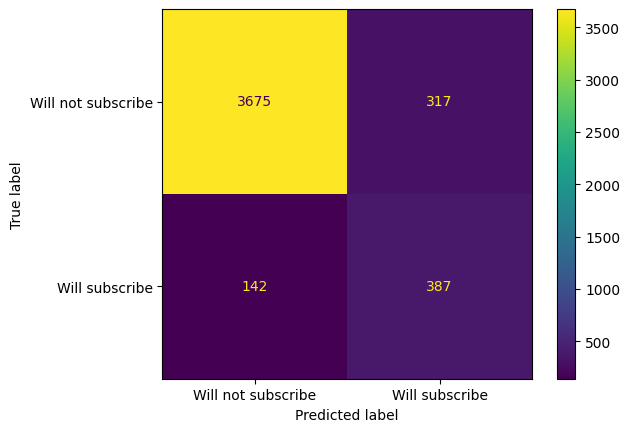

In [79]:
predictions = model2.predict(X_test_transformed)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Will not subscribe', 'Will subscribe'])
disp.plot()
plt.savefig('confusionmatrix2.png', bbox_inches='tight')

## Feature Importance

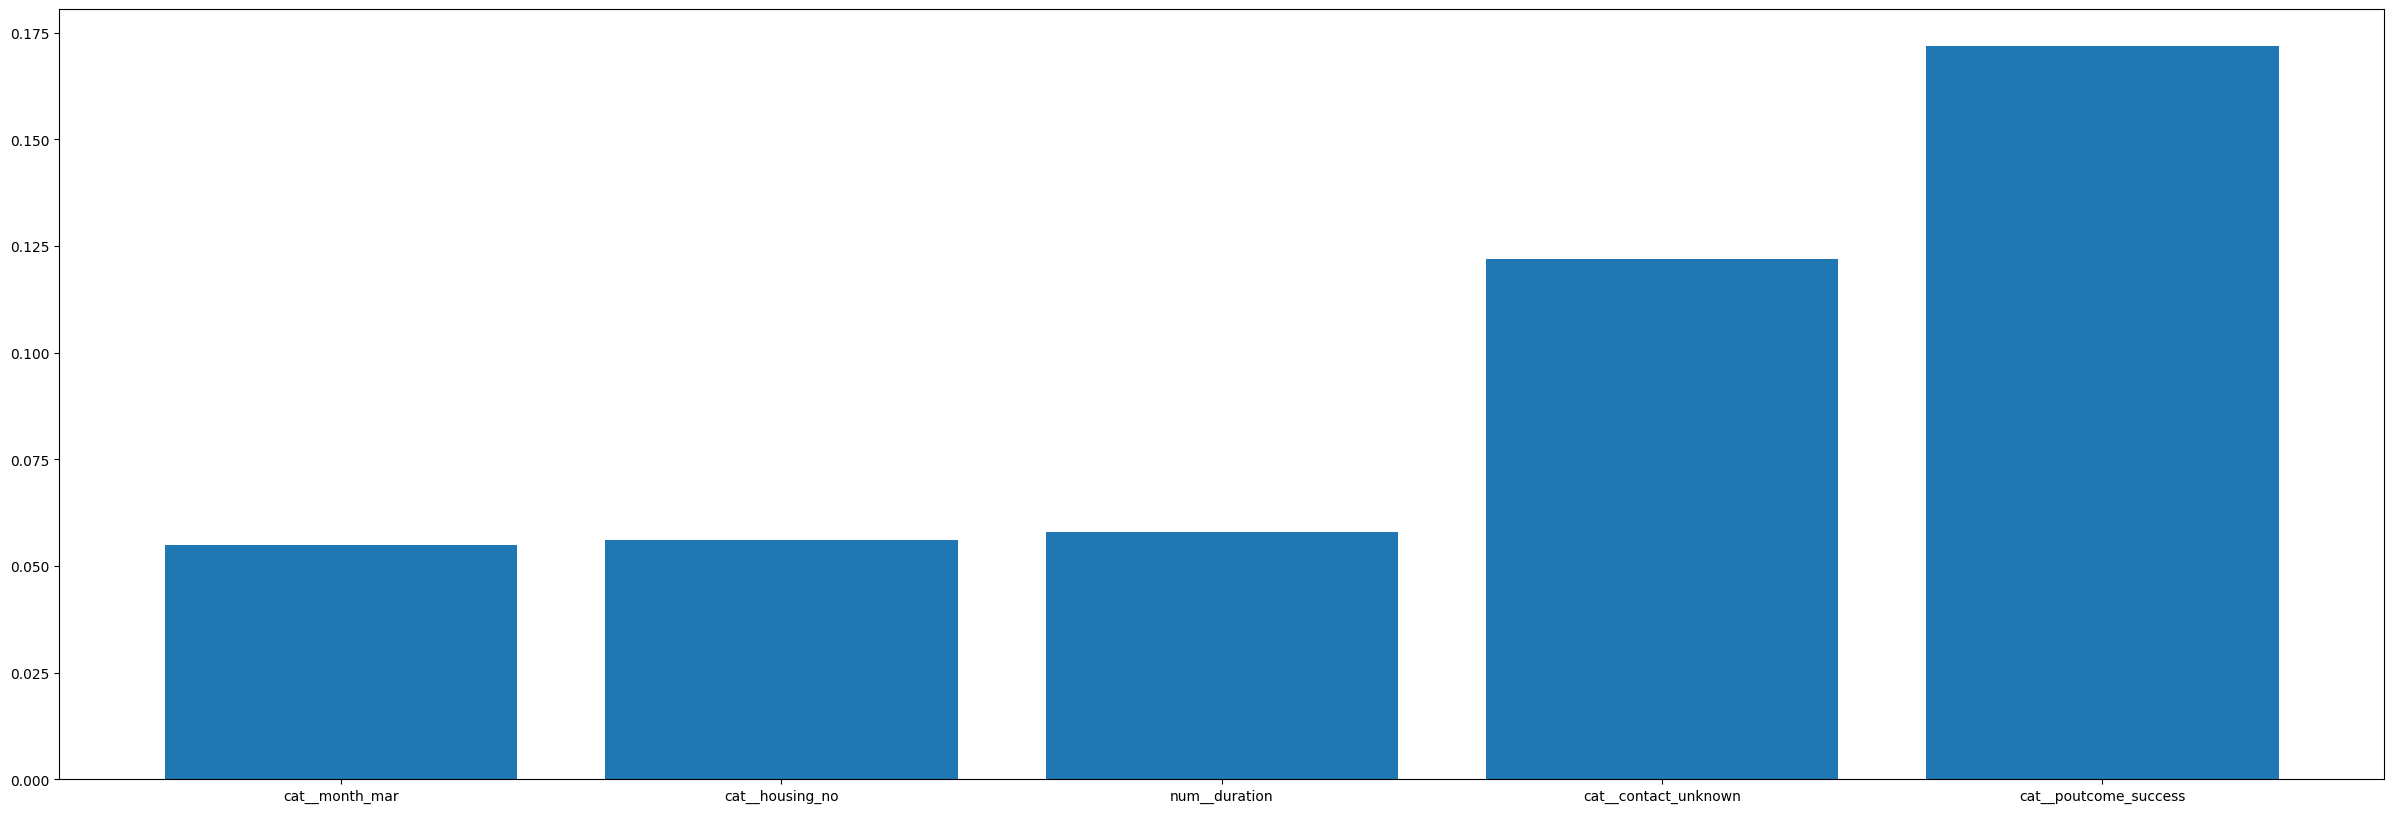

In [80]:
# All Feature names 
feature_names  = preprocessor.get_feature_names_out().tolist()

# Importance score for each feature
importance_score = model2.feature_importances_
# model2.get_booster().get_score(importance_type= 'gain')

# Zip and sort
res = dict(zip(feature_names, importance_score))
sorted_by_values = sorted(res.items(), key=lambda x:x[1])

# Top 10 features
n = 5
top_n_features = sorted_by_values[-n:]
data = dict(top_n_features)
names = list(data.keys())
values = list(data.values())
fig, ax = plt.subplots(figsize=(30, 10))
plt.bar(range(len(data)), values, tick_label=names)
plt.savefig('feature_importance.png', bbox_inches='tight')

In [81]:
contingency_table = pd.crosstab(new_df.poutcome, new_df.y, margins= False)
contingency_table

y,no,yes
poutcome,,
failure,4283,618
other,1533,307
success,533,978
unknown,33573,3386


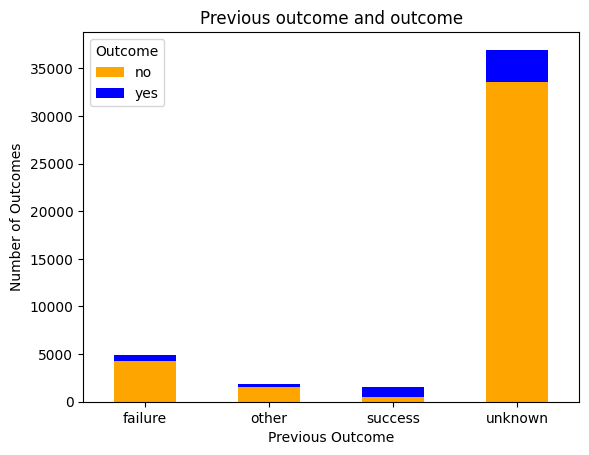

In [82]:
contingency_table.plot(kind='bar', color={'yes': 'blue', 'no': 'orange'}, stacked=True ,rot=0, 
                xlabel='Previous Outcome', ylabel='Number of Outcomes', title='Previous outcome and outcome')
plt.legend(title='Outcome')
plt.savefig('previous_outcome.png', bbox_inches='tight')

# Final Evaluation

In [83]:
# XGBoost 1st model
y_pred = xgbclf1.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9086485290864853
Precision: 0.6518324607329843
Recall: 0.4706994328922495
F1 Score: 0.5466520307354555


In [84]:
# XGBoost 2nd model
y_pred = xgbclf2.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8984737889847378
Precision: 0.5497159090909091
Recall: 0.7315689981096408
F1 Score: 0.6277372262773723


In [85]:
decisiontreeclf = DecisionTreeClassifier()
# print(randomforestclf.get_params())

clf = decisiontreeclf.fit(
    X_train_transformed,
    y_train
)

y_pred = clf.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8721521787215218
Precision: 0.45663716814159294
Recall: 0.4877126654064272
F1 Score: 0.4716636197440585


In [86]:
randomforestclf = RandomForestClassifier()
# print(randomforestclf.get_params())

clf = randomforestclf.fit(
    X_train_transformed,
    y_train
)

y_pred = clf.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9015704490157045
Precision: 0.6329113924050633
Recall: 0.3780718336483932
F1 Score: 0.47337278106508873


In [87]:
adaclf = AdaBoostClassifier(algorithm="SAMME")
# print(randomforestclf.get_params())

clf = adaclf.fit(
    X_train_transformed,
    y_train
)

y_pred = clf.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.898252598982526
Precision: 0.6236559139784946
Recall: 0.32892249527410206
F1 Score: 0.4306930693069307


In [88]:
gbclf = GradientBoostingClassifier()
# print(randomforestclf.get_params())

clf = gbclf.fit(
    X_train_transformed,
    y_train
)

y_pred = clf.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9053306790533068
Precision: 0.6525679758308157
Recall: 0.40831758034026466
F1 Score: 0.5023255813953489


# Serialization 

In [89]:
# xgbclfout = Pipeline(
#     steps=[
#         ('preprocessor', preprocessor),
#         ('model', model2)
#     ]
# )

# joblib.dump(xgbclfout, "my_model.pkl")